In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits 

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from ax.utils.notebook.plotting import render, init_notebook_plotting
# Dont do this
import warnings


warnings.filterwarnings('ignore')

In [2]:
mnistimg="https://dudeperf3ct.github.io/images/mnist_cnn_files/mnist_cnn_keras_20_0.png"
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= mnistimg,
     height=500, width=2000)

In [3]:
X = load_digits()["data"]
Y = load_digits()["target"]
# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X,Y)
# No tuning
model = RandomForestClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Score: %s" % score)

Score: 0.9511111111111111


In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colonialamerica.thinkport.org/interactives/coordinate-grids-slideshow/images/CoordinateGrid_s3.jpg",
     height=100, width=400)

## GridSearch
Loop through a grid within the hyperparameter space and evaluate objective. Pick the best result:

## Pros

- First widely used method for hyper parameter tuning
- Good for quick checks
- Samples from hyperparameter space without really knowing if its an important hyper to tune

## Cons

- Very slow and inefficient
- There are better options such as random search

In [5]:
%%timeit
parameters = {'n_estimators':[10,50,100], 'max_depth':[2,5]}
clf = RandomForestClassifier(n_jobs=-1)
# Tune with GridSearch
opt = GridSearchCV(clf, param_grid=parameters, cv=2, verbose=False)
opt.fit(X_train,y_train)
print(opt.score(X_test,y_test))

0.9377777777777778
0.9444444444444444
0.9555555555555556
0.94
0.9422222222222222
0.9444444444444444
0.9644444444444444
0.9444444444444444
3.83 s ± 95.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://analyticsindiamag.com/wp-content/uploads/2018/06/both.png",
     height=100, width=700)

## RandomSearch

The Grid Search algorithm can be very slow, owing to the potentially huge number of combinations to test. Furthermore, cross validation further increases the execution time and complexity.

Rather RS creates a range to randomly sample from using a uniform distribution


James Bergstra Yoshua Bengio (2012)


"(...) Compared with deep belief networks configured by a thoughtful combination of
manual search and grid search, purely random search over the same 32-dimensional configuration
space found statistically equal performance on four of seven data sets, and superior performance
on one of seven. A Gaussian process analysis of the function from hyper-parameters to validation
set performance reveals that for most data sets only a few of the hyper-parameters really matter,
but that different hyper-parameters are important on different data sets."


## Pros

- Adds randomness to a grid style search to more intelligently search hyperparameter space
- Given same resources will optimize it can find better results than a grid search

## Cons

- Will usually perform worst than Bayesian optimization as it only adds randomness to search and does not model distribution and take paths based on marginal probabilities
- Does not guarantee global minima

In [7]:
%%timeit
parameters = {'n_estimators':[10,50,100,200], 'max_depth':[2,4,5,10], 'min_samples_split':[2,4,6]}
clf = RandomForestClassifier(n_jobs=-1)
# Tune with RandomSearch
opt = RandomizedSearchCV(clf, param_distributions=parameters, cv=5)
opt.fit(X_train,y_train)
print("Best Score: %s " % opt.score(X_test,y_test))

Best Score: 0.9777777777777777 
Best Score: 0.9733333333333334 
Best Score: 0.9777777777777777 
Best Score: 0.9777777777777777 
Best Score: 0.9777777777777777 
Best Score: 0.9711111111111111 
Best Score: 0.9777777777777777 
Best Score: 0.9711111111111111 
18.2 s ± 2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*LB-G6WBuswEfpg20FMighA.png",
     height=100, width=600)

## Bayesian Opt

Using Bayesian Optimization and modeling our problem as a minimization of an objective function over a set of hyperparameters we can make better educated guesses during each iteration of our optimization process. Can deal with noise and is suitable for "black-box" hyper parameter optimization.
The approach is better than random search because it models your objective as a GP of your hyperparameters. Improvements in GP algo's have made BO more accesbile



## Pros

- Better scaling with parameter dimensionality
- Reduced number of experiments
- Better experiment outcomes
- Understand the parameter space
- f(x) first and second derivatives can't be observed
- Probability models with all its benefits

## Cons

- Hyperparameter space should be less than 20
- Objective function is cont (multi arm bandit for other)
- Slow. If closed source solution exists then there are better approaches

In [9]:
from ax.service.ax_client import AxClient
import ax.storage as axst
from sklearn.metrics import log_loss

def train_and_score(parameters):
    X_train, X_test, y_train, y_test = train_test_split(X,Y)
    clf = RandomForestClassifier(n_estimators=parameters["n_estimators"],
                                 max_depth=parameters["max_depth"],
                                min_samples_leaf=parameters["min_samples_leaf"])    
    clf.fit(X_train, y_train)
    
    return log_loss(y_test, clf.predict_proba(X_test))


ax_client = AxClient()


In [10]:
ax_client.create_experiment(
    name="RandomForest_MNIST",
    parameters=[
        {
            "name": "n_estimators",
            "type": "range",
            "bounds": [2, 200],
            "value_type": "int",
        },
        {
            "name": "max_depth",
            "type": "range",
            "bounds": [1, 10.0],
            "value_type": "int",
        },

        {
            "name":"min_samples_leaf",
            "type":"range",
            "bounds":[1,20],
            "value_type":"int"
        }
    ],
    objective_name="accuracy",
    minimize=False,
)


[INFO 05-16 14:14:25] ax.service.utils.dispatch: Using Bayesian Optimization generation strategy. Iterations after 5 will take longer to generate due to model-fitting.


In [11]:
N_TRIALS = 15

for _ in range(N_TRIALS):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=train_and_score(parameters))

experiment = ax_client.experiment
axst.json_store.save(experiment=experiment,filepath= "./experiment.json")
best_parameters, metrics = ax_client.get_best_parameters()


[INFO 05-16 14:14:34] ipy_plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


Best Log Loss: 1.9394689840873656


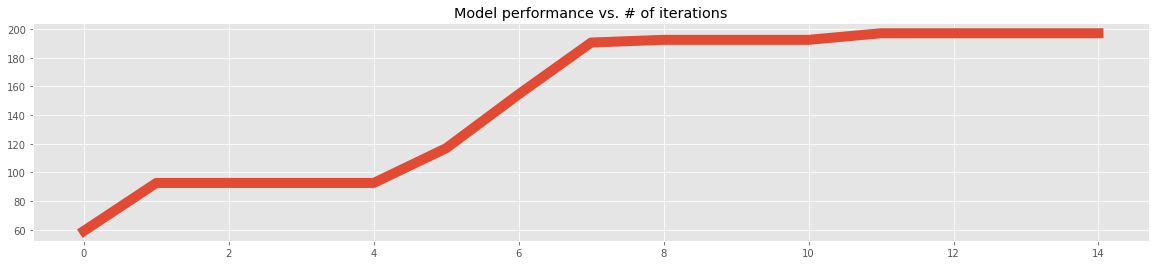

In [12]:
plt.style.use("ggplot")
init_notebook_plotting()
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
obj = list(np.maximum.accumulate(best_objectives, axis=1)[0])
plt.figure(figsize=(20,4))
plt.title("Model performance vs. # of iterations")
plt.plot(range(len(obj)), obj, linewidth=10)
print("Best Log Loss: %s" % train_and_score(best_parameters))

In [17]:
from IPython.display import HTML
HTML('<iframe src=https://ax.dev/tutorials/ width=900 height=350></iframe>')